BFRB Gesture Detection - Full Modeling Pipeline
📦 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import joblib

# Load training data
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\rahul\train.csv")
demo = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\rahul\train_demographics.csv")

# Merge demographics
df = df.merge(demo, on='subject', how='left')

print(df.shape)
df.head()

(574945, 348)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0


 2. EDA: Gesture Distribution & Sequence Structure

In [21]:
df.isna().sum()

row_id                  0
sequence_type           0
sequence_id             0
sequence_counter        0
subject                 0
                       ..
handedness              0
height_cm               0
shoulder_to_wrist_cm    0
elbow_to_wrist_cm       0
binary_label            0
Length: 349, dtype: int64

In [22]:
# Fill or drop missing
df.fillna(method="ffill", inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_1452\1425899732.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


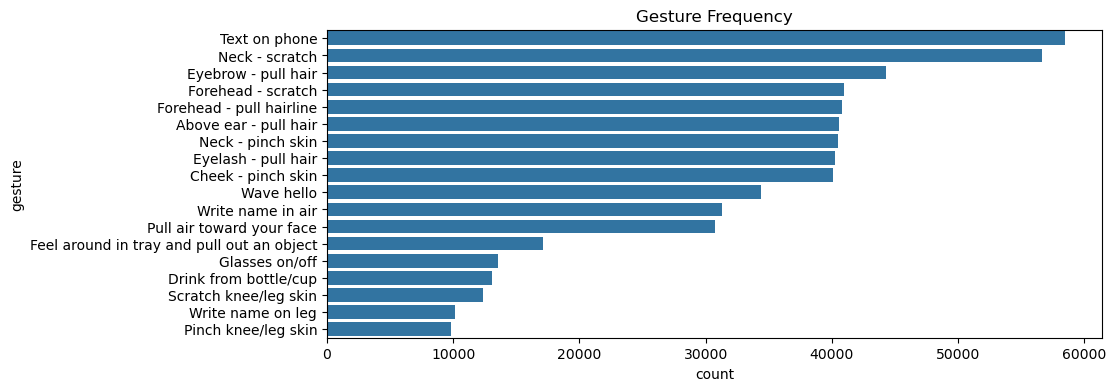

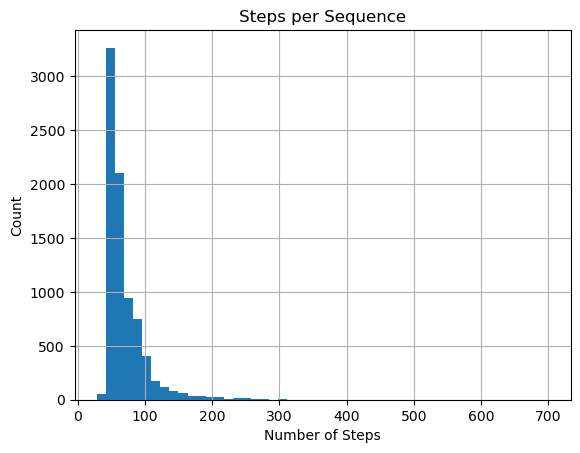

In [23]:
# Gesture frequency
plt.figure(figsize=(10,4))
sns.countplot(data=df, y='gesture', order=df['gesture'].value_counts().index)
plt.title("Gesture Frequency")
plt.show()

# Steps per sequence
step_counts = df.groupby("sequence_id")["sequence_counter"].count()
step_counts.hist(bins=50)
plt.title("Steps per Sequence")
plt.xlabel("Number of Steps")
plt.ylabel("Count")
plt.show()

3. Binary Label: BFRB vs Non-Target

In [24]:
# Mark gestures as target (BFRB) or not
target_gestures = ['Above ear - Pull hair', 'Forehead - Pull hairline', 'Forehead - Scratch','Eyebrow - Pull hair','Eyelash - Pull hair','Neck - Pinch skin','Neck - Scratch','Cheek - Pinch skin']
full_df["binary_label"] =full_df["gesture"].apply(lambda g: 1 if g in target_gestures else 0)

 4. Feature Engineering: Per Sequence

In [25]:
# Select numerical features
numerical_cols = df.select_dtypes(include='number').columns.drop(['sequence_counter'])

# Aggregate per sequence
sequence_features = df.groupby("sequence_id")[numerical_cols].mean().reset_index()

# Merge labels
label_map = df.groupby("sequence_id")[["gesture", "binary_label"]].first().reset_index()
full_df = pd.merge(sequence_features, label_map, on="sequence_id", how="left")

full_df.head()

,sequence_id,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,...,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm,binary_label_x,gesture,binary_label_y
0,SEQ_000007,6.153098,3.915570,5.577782,0.263574,-0.280817,-0.331470,-0.837994,28.630612,29.571870,...,0.0,12.0,1.0,1.0,163.0,52.0,24.0,0.0,Cheek - pinch skin,0
1,SEQ_000008,3.400506,5.311179,6.581629,0.243493,-0.117145,-0.342327,-0.875143,30.464309,29.678206,...,1.0,24.0,1.0,1.0,173.0,49.0,26.0,0.0,Forehead - pull hairline,0
2,SEQ_000013,-7.058962,2.346182,-6.068544,0.392208,0.340804,0.800506,0.002644,24.522526,24.367174,...,0.0,12.0,1.0,1.0,157.0,44.0,26.0,0.0,Cheek - pinch skin,0
3,SEQ_000016,5.524654,-4.408491,-3.162077,0.361083,-0.728107,-0.223281,-0.363684,31.651703,31.601259,...,0.0,13.0,0.0,1.0,171.0,54.0,26.0,0.0,Write name on leg,0
4,SEQ_000018,5.363715,4.109737,5.937066,0.859159,0.177468,-0.352176,-0.216601,28.903610,29.438643,...,0.0,13.0,0.0,1.0,165.0,52.0,23.0,0.0,Forehead - pull hairline,0


5. Feature Selection: F-score & PCA

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


Top Features: ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z', 'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_1_v1', 'tof_1_v2', 'tof_1_v3', 'tof_1_v4', 'tof_1_v5', 'tof_1_v6', 'tof_1_v7']


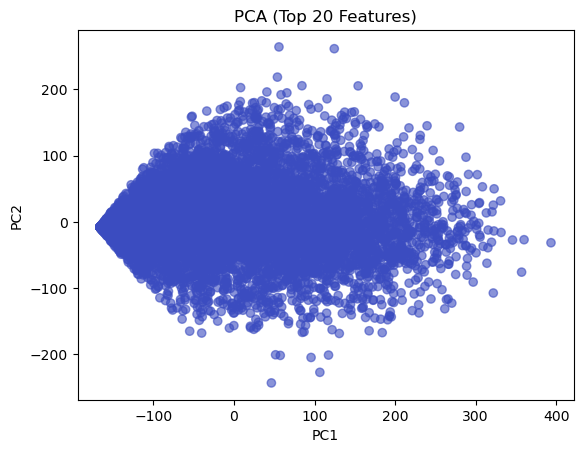

In [26]:
# F-score selection
target_gestures = ['Above ear - Pull hair', 'Forehead - Pull hairline', 'Forehead - Scratch','Eyebrow - Pull hair','Eyelash - Pull hair','Neck - Pinch skin','Neck - Scratch','Cheek - Pinch skin']
full_df["binary_label"] =full_df["gesture"].apply(lambda g: 1 if g in target_gestures else 0)


X = full_df.drop(columns=["sequence_id", "gesture", "binary_label"])
y = full_df["binary_label"]

f_scores, _ = f_classif(X, y)
feature_scores = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

top_features = feature_scores.head(20).index.tolist()
print("Top Features:", top_features)

# Optional: PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[top_features])
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA (Top 20 Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [51]:
top_features = feature_scores.head(20).index.tolist()

# Save feature order used for training
joblib.dump(top_features, "top_features.pkl")

['top_features.pkl']

6. Train Binary Classifier (BFRB vs Non-Target)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X[top_features], y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1631

    accuracy                           1.00      1631
   macro avg       1.00      1.00      1.00      1631
weighted avg       1.00      1.00      1.00      1631



 7. Train Multiclass Classifier (Specific Gesture)

In [39]:
print(full_df["gesture"].unique())

['Cheek - pinch skin' 'Forehead - pull hairline' 'Write name on leg'
 'Feel around in tray and pull out an object' 'Neck - scratch'
 'Neck - pinch skin' 'Eyelash - pull hair' 'Eyebrow - pull hair'
 'Forehead - scratch' 'Above ear - pull hair' 'Wave hello'
 'Write name in air' 'Text on phone' 'Pull air toward your face'
 'Pinch knee/leg skin' 'Scratch knee/leg skin' 'Drink from bottle/cup'
 'Glasses on/off']


In [40]:
# See what gestures are present
unique_gestures = full_df["gesture"].unique()

# Try partial match for inspection
for gesture in unique_gestures:
    for keyword in ["pull", "scratch", "pinch"]:
        if keyword.lower() in gesture.lower():
            print(gesture)

Cheek - pinch skin
Forehead - pull hairline
Feel around in tray and pull out an object
Neck - scratch
Neck - pinch skin
Eyelash - pull hair
Eyebrow - pull hair
Forehead - scratch
Above ear - pull hair
Pull air toward your face
Pinch knee/leg skin
Scratch knee/leg skin


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Fix gesture names first
target_gestures = ['Cheek - pinch skin', 'Forehead - pull hairline', 'Feel around in tray and pull out an object','Neck - scratch','Neck - pinch skin','Eyelash - pull hair','Eyebrow - pull hair','Forehead - scratch','Above ear - pull hair','Pull air toward your face','Pinch knee/leg skin','Scratch knee/leg skin']
# Filter only BFRB gestures
bfrb_df = full_df[full_df["gesture"].isin(target_gestures)].copy()
print("Rows with BFRB gestures:", bfrb_df.shape[0])

# Encode gestures into labels
le = LabelEncoder()
bfrb_df["gesture_label"] = le.fit_transform(bfrb_df["gesture"])

# Drop missing values in selected features
X_bfrb = bfrb_df[top_features].dropna()
y_bfrb = bfrb_df.loc[X_bfrb.index, "gesture_label"]

# Only proceed if there's enough data
if len(X_bfrb) > 1:
    X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
        X_bfrb, y_bfrb, test_size=0.2, stratify=y_bfrb, random_state=42)

    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train_b, y_train_b)

    y_pred_b = xgb_model.predict(X_val_b)
    print(classification_report(y_val_b, y_pred_b, target_names=le.classes_))
else:
    print("❌ Not enough BFRB samples to train a multiclass model.")

Rows with BFRB gestures: 6073
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.63      0.59      0.61       128
                        Cheek - pinch skin       0.46      0.45      0.45       128
                       Eyebrow - pull hair       0.20      0.20      0.20       128
                       Eyelash - pull hair       0.33      0.31      0.32       128
Feel around in tray and pull out an object       0.93      0.84      0.89        32
                  Forehead - pull hairline       0.44      0.46      0.45       128
                        Forehead - scratch       0.52      0.58      0.55       128
                         Neck - pinch skin       0.31      0.32      0.32       128
                            Neck - scratch       0.38      0.37      0.37       128
                       Pinch knee/leg skin       0.44      0.44      0.44        32
                 Pull air toward your face   

8. Save Models

In [43]:
joblib.dump(rf, "binary_classifier_stage1.pkl")
joblib.dump(xgb_model, "multiclass_classifier_stage2.pkl")
joblib.dump(le, "label_encoder_stage2.pkl")

['label_encoder_stage2.pkl']

9. Predict on Test Data (Per Sequence)


In [52]:
import pandas as pd
import joblib

# === Step 1: Load Models and Feature List ===
rf = joblib.load("binary_classifier_stage1.pkl")
xgb_model = joblib.load("multiclass_classifier_stage2.pkl")
le = joblib.load("label_encoder_stage2.pkl")
top_features = joblib.load("top_features.pkl")

# === Step 2: Load Test Data and Demographics ===
test_df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\rahul\test.csv")
test_demo = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\rahul\test_demographics.csv")
test_df = test_df.merge(test_demo, on='subject', how='left')

# === Step 3: Preprocess Test Data ===
# Fill missing values forward (optional, must match training strategy)
test_df.fillna(method="ffill", inplace=True)

# Aggregate per sequence
numerical_cols = test_df.select_dtypes(include='number').columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'sequence_id']
seq_feats = test_df.groupby("sequence_id")[numerical_cols].mean().reset_index()

# Ensure correct feature columns and order
X_test = seq_feats[top_features].copy()  # Match exactly
sequence_ids = seq_feats["sequence_id"]

# === Step 4: Predict and Classify ===
preds = []
for i in range(len(X_test)):
    x = X_test.iloc[[i]]
    is_bfrb = rf.predict(x)[0]
    
    if is_bfrb == 1:
        gesture_class = xgb_model.predict(x)[0]
        gesture = le.inverse_transform([gesture_class])[0]
    else:
        gesture = "non_target"
    
    preds.append(gesture)

# === Step 5: Save Submission ===
submission = pd.DataFrame({
    "sequence_id": sequence_ids,
    "gesture": preds
})

submission.to_csv("bfrb_submission.csv", index=False)
print("✅ Submission saved as: bfrb_submission.csv")

✅ Submission saved as: bfrb_submission.csv


C:\Users\DELL\AppData\Local\Temp\ipykernel_1452\616023400.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method="ffill", inplace=True)
